
# Zonal Statistics with Geopandas and Rasterio

**Brek Chiles, 2025**



### Purpose

This notebook implements zonal statistic analysis with Geopandas and Rasterio to examine the slope of main roadways in Central Redmond, WA. Code examples for map creation, data analysis, and data management demonstrate the extensive capabilities of Geopandas and other Python packages for geospatial applications.


In [1]:
# Import modules
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot
from rasterio.mask import mask
import numpy as np
import rasterstats

# Modules for plots
import seaborn
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib_map_utils.core.north_arrow import north_arrow
from matplotlib_map_utils.core.scale_bar import scale_bar
from scipy.stats import linregress


### Data Handling

Before running the code cells, create a directory to contain input and output datasets. Input datasets in this notebook are obtainable through the repository, but you are encouraged to try datasets for another area of interest. Geopandas combines Pandas and Shapely utilities to handle geometric or vector data and tabular data. Rasterio will handle... you guessed it, raster data. In the following code cell Geopandas (gpd.read_file()) reads the boundary and roads files and Rasterio (rio.open()) opens the elevation and slope data. Descriptive variable names will help keep track of their corresponding input dataset.

**Note:** The hillshade (redmond_hillshade) and study area (study_area) are only used for map plotting. Refer to the Datasets and GDAL Workflow sections of the repository for more information.


In [2]:
# Rasters
redmond_elev = rio.open(r'C:\Users\brekc\OneDrive\Desktop\GIS_PROJECTS\Road_Slope_Analysis_Education_Hill\Python_Method\Inputs\DEM\King_Co_2021_Ext.tif')
redmond_hillshade = rio.open(r'C:\Users\brekc\OneDrive\Desktop\GIS_PROJECTS\Road_Slope_Analysis_Education_Hill\Python_Method\Inputs\DEM\King_Co_2021_SR.tif')
redmond_slope_perc = rio.open(r'C:\Users\brekc\OneDrive\Desktop\GIS_PROJECTS\Road_Slope_Analysis_Education_Hill\Python_Method\Inputs\DEM\King_Co_2021_Ext_Perc.tif')

# Vectors/Geometries
redmond_roads = gpd.read_file(r'C:\Users\brekc\OneDrive\Desktop\GIS_PROJECTS\Road_Slope_Analysis_Education_Hill\Python_Method\Inputs\Roads\Redmond_Roads.shp')
redmond_neighborhoods = gpd.read_file(r'C:\Users\brekc\OneDrive\Desktop\GIS_PROJECTS\Road_Slope_Analysis_Education_Hill\Python_Method\Inputs\Boundary\Redmond_Neighborhoods.shp')
study_area = gpd.read_file(r'C:\Users\brekc\OneDrive\Desktop\GIS_PROJECTS\Road_Slope_Analysis_Education_Hill\Python_Method\Inputs\Boundary\Redmond_Neighborhoods_Dissolve.shp')


**Check Coordinate Reference Systems (CRS) and units**


In [3]:
redmond_elev.crs

CRS.from_wkt('PROJCS["NAD83(HARN) / Washington North (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4152"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",47],PARAMETER["central_meridian",-120.833333333333],PARAMETER["standard_parallel_1",48.7333333333333],PARAMETER["standard_parallel_2",47.5],PARAMETER["false_easting",1640416.667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2926"]]')

In [4]:
redmond_elev.crs.linear_units

'US survey foot'

In [5]:
redmond_neighborhoods.crs

<Compound CRS: COMPD_CS["NAD83(HARN) / Washington North (ftUS) +  ...>
Name: NAD83(HARN) / Washington North (ftUS) + NGVD29 height (ftUS)
Axis Info [cartesian|vertical]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
- [up]: Gravity-related height (US survey foot)
Area of Use:
- undefined
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Sub CRS:
- NAD83(HARN) / Washington North (ftUS)
- NGVD29 height (ftUS)

In [6]:
redmond_neighborhoods.crs.axis_info[0].unit_name

'US survey foot'


A GeoDataFrame (gdf) is a Pandas DataFrame (df) with Shapely objects stored in a geometry column. The following code cells will leverage regular Pandas functions and methods to perform data manipulation.


In [7]:
# Inspect fields of redmond_neighborhoods
redmond_neighborhoods.columns.values

array(['NAME', 'ABBEVIATIO', 'CreatedBy', 'DateCreate', 'ModifiedBy',
       'DateModifi', 'GlobalID', 'Shape_STAr', 'Shape_STLe', 'geometry'],
      dtype=object)


**.copy():** The .copy() method duplicates a gdf/df and allows users to both modify copied data and preserve the original data.


In [8]:
# Create a copy of the neighborhoods gdf with selected columns
neighborhoods_gdf = redmond_neighborhoods[['NAME', 'Shape_STAr', 'geometry']].copy()
neighborhoods_gdf

NAME    Shape_STAr  \
0        SE Redmond  7.072032e+07   
1        Bear Creek  2.116149e+07   
2          Downtown  2.872513e+07   
3    Education Hill  6.456969e+07   
4  Sammamish Valley  3.487231e+07   
5     North Redmond  4.404046e+07   

                                            geometry  
0  POLYGON ((1331492.127 250737.713, 1331609.699 ...  
1  POLYGON ((1330507.597 254243.099, 1330507.625 ...  
2  POLYGON ((1320591.56 254172.571, 1320660.641 2...  
3  POLYGON ((1323028.787 259030.377, 1323056.851 ...  
4  POLYGON ((1315406.104 260984.801, 1316571.852 ...  
5  POLYGON ((1326356.67 263200.511, 1326367.19 26...

In [9]:
# Inspect fields of redmond_roads
redmond_roads.columns.values

array(['StreetName', 'FromStreet', 'ToStreet', 'StreetWidt', 'ConstYear',
       'd_Classifi', 'd_Ownershi', 'd_Status', 'd_DataSour', 'd_InsideCi',
       'FromLeft', 'ToLeft', 'FromRight', 'ToRight', 'LeftCity',
       'RightCity', 'LeftZip', 'RightZip', 'Side', 'Exclude', 'lz_evn',
       'lz_odd', 'la_evn', 'la_odd', 'StreetNa_1', 'FireArteri',
       'surface', 'd_ConstBy', 'MaxSpeedLi', 'CreatedBy', 'DateCreate',
       'ModifiedBy', 'DateModifi', 'StAlias1', 'StAlias2', 'StAlias3',
       'AssetID', 'LucityAuto', 'd_AssetTyp', 'CalcLength', 'Location',
       'GlobalID', 'StAlias4', 'Shape_STLe', 'geometry'], dtype=object)

In [10]:
# Create a copy of the Redmond Roads gdf with selected columns
redmond_roads_gdf = redmond_roads[['StreetName', 'FromStreet', 'ToStreet','geometry']].copy()
redmond_roads_gdf.head()

StreetName         FromStreet      ToStreet  \
0     NE 116th ST        167th PL NE   167th PL NE   
1     NE 116th ST        176th PL NE  176th AVE NE   
2     NE 114th CT  W of 159th AVE NE  159th AVE NE   
3     NE 114th ST  W of 148th AVE NE  148th AVE NE   
4  RED-WOOD RD NE        NE 113th CT   NE 116th ST   

                                            geometry  
0  LINESTRING (1324032.261 259389.496, 1324373.77...  
1  LINESTRING (1327052.127 259309.378, 1327082.21...  
2  LINESTRING (1321723.018 259046.304, 1321724.01...  
3  LINESTRING (1317925.193 258700.349, 1318097.10...  
4  LINESTRING (1320654.273 258647.865, 1320690.97...


### Make a Study Area Map

The next code cells will plot a map of main roadways in Central Redmond, WA. Rasterio reads raster data (try saying that three times fast) as Numpy arrays and can mask nodata values. 

In [11]:
# Create masked arrays for plotting
elev_array = redmond_elev.read(1, masked=True)
hillshade_array = redmond_hillshade.read(1, masked=True)
slope_perc_array = redmond_slope_perc.read(1, masked=True)

In [12]:
# Plotting extent
plt_extent = rio.plot.plotting_extent(redmond_hillshade)

Text(134.21556206492733, 0.5, 'Northing')

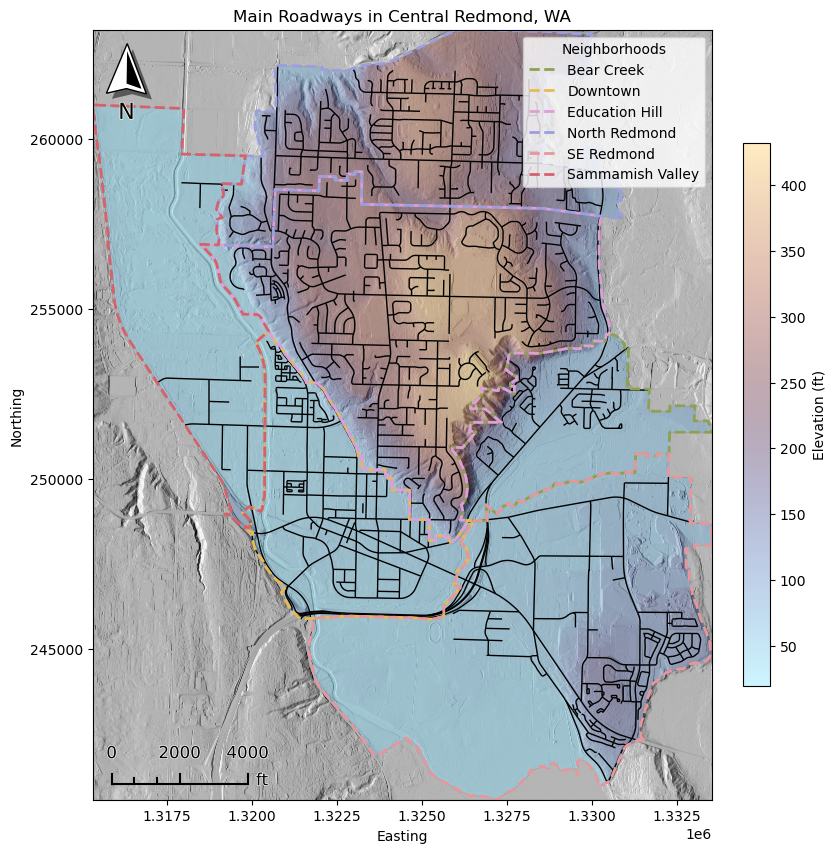

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster data and main roadways
hillshade_plot = ax.imshow(hillshade_array, cmap='gray', extent=plt_extent)
elev_plot = ax.imshow(elev_array, cmap='managua_r', alpha=0.4, extent=plt_extent)
redmond_roads_gdf.plot(ax=ax, color='Black', linewidth=1)

# Plot the neighborhood boundaries with different edgeline colors
for name, group in neighborhoods_gdf.groupby('NAME'):
    group.boundary.plot(
        ax=ax,
        linestyle='--',
        linewidth=2,
        label=name,
        edgecolor=plt.cm.tab20b(hash(name) % 21)
    )

# Add a legend, north arrow, and scale bar
ax.legend(title='Neighborhoods', loc='upper right', frameon=True)
north_arrow(ax, location="upper left", rotation={"crs": redmond_roads_gdf.crs, "reference": "center"})
scale_bar(ax, location="lower left", style="ticks", bar={"projection": redmond_roads_gdf.crs, "unit": "ftUS", "max": 4000, "major_div": 2, "minor_div":3})
cbar = plt.colorbar(elev_plot, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label('Elevation (ft)')

# Add title and labels
plt.title('Main Roadways in Central Redmond, WA')
plt.xlabel('Easting')
plt.ylabel('Northing')


### Zonal Statistics with Geopandas and Rasterio 

This section builds a tool to extract zonal statistics from a raster dataset with zones or boundaries. The zonal statistics tool will use Geopandas to access geometries and write statistics for new fields. Numpy functions can calculate statistics from a masked array created with Rasterio. Let's calculate zonal statistics for a single zone first, then build functions to iterate over multiple zones.



**Zonal Statistics Example for Education Hill**


In [14]:
# Get geometry of the Education Hill neighborhood
education_hill_boundary = neighborhoods_gdf.iloc[3].geometry
# Check the geometry type
education_hill_boundary.geometryType

<bound method BaseGeometry.geometryType of <POLYGON ((1323028.787 259030.377, 1323056.851 259029.421, 1323124.12 259027...>>

In [15]:
# What is the geometry column?
type(neighborhoods_gdf['geometry'])

geopandas.geoseries.GeoSeries

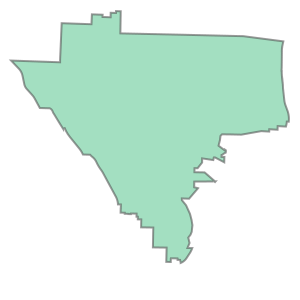

In [16]:
# What does the polygon look like?
education_hill_boundary


Education Hill seems to have the highest areas based on the study area map. Zonal statistics can help examine elevations within the neighborhood.


In [17]:
# Use the mask function from Rasterio to create an array that only includes the Education Hill neighborhood
education_hill_mask, education_hill_mask_transform = mask(
    dataset=redmond_elev,
    shapes=[education_hill_boundary],
    crop=True,
    all_touched=True,
    filled=False,
    indexes=1
)
# education_hill_mask is the numpy array of elevation values
education_hill_mask

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [18]:
# education_hill_mask_transform is an affine matrix describing the transformation from pixel coordinates to geographic coordinates
education_hill_mask_transform

Affine(1.499853471968382, 0.0, 1318488.689379101,
       0.0, -1.499817855808718, 259031.10639685177)

In [19]:
# Check the shape (columns and rows) of the masked array
education_hill_mask.shape

(7269, 8018)

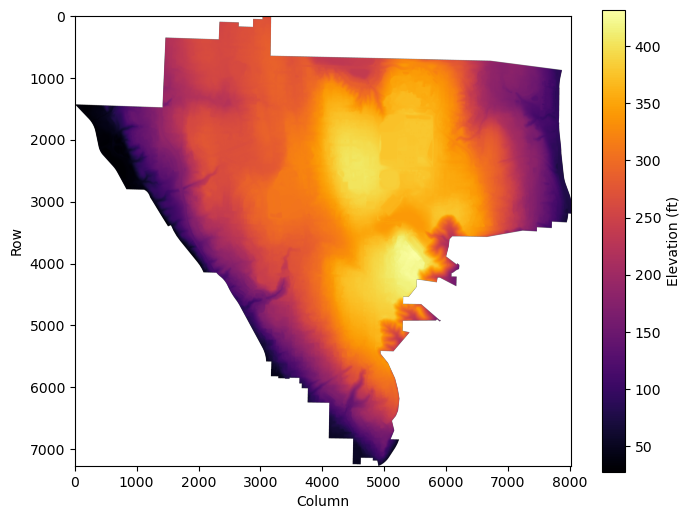

In [20]:
# Quick plot of the Education Hill elevation mask
plt.figure(figsize=(8, 6))
plt.imshow(education_hill_mask, cmap='inferno')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='Elevation (ft)')
plt.show()

In [21]:
# Count the number of nonmasked pixels/cells in the Education Hill elevation mask
education_hill_mask.count()

np.int64(28720194)


**Area Calculations with Raster Data:** We have a count of pixels and can obtain pixel size through an affine transformation.


In [22]:
area_calculation = education_hill_mask.count() * (education_hill_mask_transform[0]**2)
f'{area_calculation} square ft'

'64607812.17615238 square ft'


Find the minimum (.min()), maximum (.max()), and mean (.mean()) elevation values of Education Hill.


In [23]:
# Calculate the minimum, maximum, and mean elevation values in Education Hill
f'Min - {education_hill_mask.min()} ft, Max - {education_hill_mask.max()} ft, Mean - {education_hill_mask.mean()} ft'

'Min - 27.688194274902344 ft, Max - 431.5178527832031 ft, Mean - 263.5837704996004 ft'


Extracting zonal statistics from zones individually can be costly if you are working with large datasets and multiple zones. We will use a function to create the masked arrays over the entire geometry column. The **.apply()** function will apply the masked array function and Numpy functions to obtain zonal statistics.


In [24]:
# Function for elevation masked arrays
def elev_masked_array(geom, data=redmond_elev, **mask_args):
    elev_masked, elev_mask_transform = mask(dataset=data, shapes=[geom],
                                  crop=True, all_touched=True, filled=False, indexes=1)
    return elev_masked


The count of cells within a zone is another useful statistic to have, let's use another function to extract that.


In [25]:
# Function for counting nonmasked raster cells
def cell_count(masked_array):
    cells = masked_array.count()
    return cells


Later on, we will use the roadway dataset to demonstrate geometric operations in GeoPandas. We could create a function to accept any raster input, but hardcoding the input avoids overcomplicating the .apply() function.

*"There is no harm in repeating a good thing" - Plato, The Statesman, 360 BC*


In [26]:
# Function for extracting statistics from masked slope array
def slope_masked_array(geom, data=redmond_slope_perc, **mask_args):
    slope_masked, slope_mask_transform = mask(dataset=data, shapes=[geom],
                                  crop=True, all_touched=True, filled=False, indexes=1)
    return slope_masked


## **The Moment You've All Been Waiting For**


In [27]:
# Extract elevation statistics for each neighborhood
neighborhoods_gdf['Cell_Count'] = neighborhoods_gdf.geometry.apply(elev_masked_array).apply(cell_count)
neighborhoods_gdf['mean_elev_ft'] = neighborhoods_gdf.geometry.apply(elev_masked_array).apply(np.mean)
neighborhoods_gdf['min_elev_ft'] = neighborhoods_gdf.geometry.apply(elev_masked_array).apply(np.min)
neighborhoods_gdf['max_elev_ft'] = neighborhoods_gdf.geometry.apply(elev_masked_array).apply(np.max)
neighborhoods_gdf

NAME    Shape_STAr  \
0        SE Redmond  7.072032e+07   
1        Bear Creek  2.116149e+07   
2          Downtown  2.872513e+07   
3    Education Hill  6.456969e+07   
4  Sammamish Valley  3.487231e+07   
5     North Redmond  4.404046e+07   

                                            geometry  Cell_Count  \
0  POLYGON ((1331492.127 250737.713, 1331609.699 ...    31443982   
1  POLYGON ((1330507.597 254243.099, 1330507.625 ...     9415251   
2  POLYGON ((1320591.56 254172.571, 1320660.641 2...    12779654   
3  POLYGON ((1323028.787 259030.377, 1323056.851 ...    28720194   
4  POLYGON ((1315406.104 260984.801, 1316571.852 ...    15507864   
5  POLYGON ((1326356.67 263200.511, 1326367.19 26...    19584198   

   mean_elev_ft  min_elev_ft  max_elev_ft  
0     64.968724    23.599998   180.052658  
1     84.387484    40.703487   422.572144  
2     41.672199    21.599064   124.803383  
3    263.583770    27.688194   431.517853  
4     32.934184    19.570000   132.508057  
5    222.029285    32.145237   342.195099


Based on the elevation statistics for each neighborhood, we can confirm that Education Hill has the highest areas.
  

In [28]:
# Sort the neighborhoods by mean elevation
neighborhoods_gdf.sort_values(by='mean_elev_ft', ascending=False)

NAME    Shape_STAr  \
3    Education Hill  6.456969e+07   
5     North Redmond  4.404046e+07   
1        Bear Creek  2.116149e+07   
0        SE Redmond  7.072032e+07   
2          Downtown  2.872513e+07   
4  Sammamish Valley  3.487231e+07   

                                            geometry  Cell_Count  \
3  POLYGON ((1323028.787 259030.377, 1323056.851 ...    28720194   
5  POLYGON ((1326356.67 263200.511, 1326367.19 26...    19584198   
1  POLYGON ((1330507.597 254243.099, 1330507.625 ...     9415251   
0  POLYGON ((1331492.127 250737.713, 1331609.699 ...    31443982   
2  POLYGON ((1320591.56 254172.571, 1320660.641 2...    12779654   
4  POLYGON ((1315406.104 260984.801, 1316571.852 ...    15507864   

   mean_elev_ft  min_elev_ft  max_elev_ft  
3    263.583770    27.688194   431.517853  
5    222.029285    32.145237   342.195099  
1     84.387484    40.703487   422.572144  
0     64.968724    23.599998   180.052658  
2     41.672199    21.599064   124.803383  
4     32.934184    19.570000   132.508057


Before extracting zonal statistics for roads in Central Redmond, we should consider applying a buffer to the geometries. Buffering roadway centerlines will better represent the surrounding topography in the zonal statistics.

**Note:** The geometries will now be polygons instead of lines/linestrings.


In [29]:
# Copy the roads gdf, then buffer the geometry to 50 feet
redmond_roads_gdf_50ft = redmond_roads_gdf.copy()
redmond_roads_gdf_50ft['geometry'] = redmond_roads_gdf_50ft.buffer(50)
redmond_roads_gdf_50ft.head()

StreetName         FromStreet      ToStreet  \
0     NE 116th ST        167th PL NE   167th PL NE   
1     NE 116th ST        176th PL NE  176th AVE NE   
2     NE 114th CT  W of 159th AVE NE  159th AVE NE   
3     NE 114th ST  W of 148th AVE NE  148th AVE NE   
4  RED-WOOD RD NE        NE 113th CT   NE 116th ST   

                                            geometry  
0  POLYGON ((1324375.024 259430.934, 1324379.918 ...  
1  POLYGON ((1327083.655 259358.493, 1327232.295 ...  
2  POLYGON ((1321674.046 259077.955, 1321674.45 2...  
3  POLYGON ((1318098.49 258745.577, 1318099.366 2...  
4  POLYGON ((1320641.017 259499.219, 1320641.469 ...

In [30]:
# Extract slope (%) statistics for each road segment
redmond_roads_gdf_50ft['cell_count'] = redmond_roads_gdf_50ft.geometry.apply(slope_masked_array).apply(cell_count)
redmond_roads_gdf_50ft['mean_elev_ft'] = redmond_roads_gdf_50ft.geometry.apply(elev_masked_array).apply(np.mean)
redmond_roads_gdf_50ft['min_slope_%'] = redmond_roads_gdf_50ft.geometry.apply(slope_masked_array).apply(np.min)
redmond_roads_gdf_50ft['max_slope_%'] = redmond_roads_gdf_50ft.geometry.apply(slope_masked_array).apply(np.max)
redmond_roads_gdf_50ft['mean_slope_%'] = redmond_roads_gdf_50ft.geometry.apply(slope_masked_array).apply(np.mean)
redmond_roads_gdf_50ft['mean_slope_std'] = redmond_roads_gdf_50ft.geometry.apply(slope_masked_array).apply(np.std)
redmond_roads_gdf_50ft

StreetName         FromStreet      ToStreet  \
0        NE 116th ST        167th PL NE   167th PL NE   
1        NE 116th ST        176th PL NE  176th AVE NE   
2        NE 114th CT  W of 159th AVE NE  159th AVE NE   
3        NE 114th ST  W of 148th AVE NE  148th AVE NE   
4     RED-WOOD RD NE        NE 113th CT   NE 116th ST   
...              ...                ...           ...   
1515     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1516    192nd AVE NE       191st AVE NE   NE 69th CIR   
1517     NE 69th CIR        NE 69th CIR    NE 70th ST   
1518     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1519    188th AVE NE       188th AVE NE    NE 70th ST   

                                               geometry  cell_count  \
0     POLYGON ((1324375.024 259430.934, 1324379.918 ...       19041   
1     POLYGON ((1327083.655 259358.493, 1327232.295 ...       11681   
2     POLYGON ((1321674.046 259077.955, 1321674.45 2...       12557   
3     POLYGON ((1318098.49 258745.577, 1318099.366 2...       28828   
4     POLYGON ((1320641.017 259499.219, 1320641.469 ...       41998   
...                                                 ...         ...   
1515  POLYGON ((1332322.63 245646.177, 1332320.234 2...        6893   
1516  POLYGON ((1332161.94 245707.139, 1332161.916 2...       12678   
1517  POLYGON ((1332332.166 245895.207, 1332332.803 ...       15969   
1518  POLYGON ((1332304.663 245830.908, 1332304.668 ...        8995   
1519  POLYGON ((1331297.202 246030.049, 1331297.17 2...       19631   

      mean_elev_ft  min_slope_%  max_slope_%  mean_slope_%  mean_slope_std  
0       276.278688     0.252355   239.191376     16.277520       17.955291  
1       222.748994     0.119722    67.267960      9.969143        5.941382  
2       247.744923     0.026077    76.766327      6.418974        5.367366  
3        32.806479     0.015104    65.881775      9.408861        7.857528  
4       205.727701     0.030132    91.540848     11.151787       10.825096  
...            ...          ...          ...           ...             ...  
1515    138.891974     0.114905    95.899033     16.050704       18.487779  
1516    128.058112     0.057999    93.004593     30.234796       23.203174  
1517    141.915806     0.046515   103.240211     10.788101       13.938386  
1518    141.051862     0.123526    73.318863     14.728122       15.647530  
1519    114.202639     0.048805    73.832268     10.044362       10.725548  

[1520 rows x 10 columns]


Reading values between zones can be confusing at times. Try classifying slope grades to help interpret the results.


In [31]:
# Create a classification field based on a choice list and conditions (slope_grade_thresholds)
slope_grade_thresholds = [
	(redmond_roads_gdf_50ft['mean_slope_%'] >= 0) & (redmond_roads_gdf_50ft['mean_slope_%'] <= 9),
	(redmond_roads_gdf_50ft['mean_slope_%'] > 9) & (redmond_roads_gdf_50ft['mean_slope_%'] <= 15),
	(redmond_roads_gdf_50ft['mean_slope_%'] > 15) & (redmond_roads_gdf_50ft['mean_slope_%'] <= 30),
	(redmond_roads_gdf_50ft['mean_slope_%'] > 30) & (redmond_roads_gdf_50ft['mean_slope_%'] <= 60)
]

# Choice list
slope_grade_classifications = [1, 2, 3, 4]
slope_grade_classifications_2 = ['Gentle', 'Moderate', 'Steep', 'Very Steep']

# Make a new field to classify roadways based on mean slope
redmond_roads_gdf_50ft['slope_class'] = np.select(slope_grade_thresholds, slope_grade_classifications)

# Change the values in the slope_class field to a strings
redmond_roads_gdf_50ft['slope_class'] = redmond_roads_gdf_50ft['slope_class'].replace(
	dict(zip(slope_grade_classifications, slope_grade_classifications_2))
)

# Check the new field
redmond_roads_gdf_50ft

StreetName         FromStreet      ToStreet  \
0        NE 116th ST        167th PL NE   167th PL NE   
1        NE 116th ST        176th PL NE  176th AVE NE   
2        NE 114th CT  W of 159th AVE NE  159th AVE NE   
3        NE 114th ST  W of 148th AVE NE  148th AVE NE   
4     RED-WOOD RD NE        NE 113th CT   NE 116th ST   
...              ...                ...           ...   
1515     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1516    192nd AVE NE       191st AVE NE   NE 69th CIR   
1517     NE 69th CIR        NE 69th CIR    NE 70th ST   
1518     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1519    188th AVE NE       188th AVE NE    NE 70th ST   

                                               geometry  cell_count  \
0     POLYGON ((1324375.024 259430.934, 1324379.918 ...       19041   
1     POLYGON ((1327083.655 259358.493, 1327232.295 ...       11681   
2     POLYGON ((1321674.046 259077.955, 1321674.45 2...       12557   
3     POLYGON ((1318098.49 258745.577, 1318099.366 2...       28828   
4     POLYGON ((1320641.017 259499.219, 1320641.469 ...       41998   
...                                                 ...         ...   
1515  POLYGON ((1332322.63 245646.177, 1332320.234 2...        6893   
1516  POLYGON ((1332161.94 245707.139, 1332161.916 2...       12678   
1517  POLYGON ((1332332.166 245895.207, 1332332.803 ...       15969   
1518  POLYGON ((1332304.663 245830.908, 1332304.668 ...        8995   
1519  POLYGON ((1331297.202 246030.049, 1331297.17 2...       19631   

      mean_elev_ft  min_slope_%  max_slope_%  mean_slope_%  mean_slope_std  \
0       276.278688     0.252355   239.191376     16.277520       17.955291   
1       222.748994     0.119722    67.267960      9.969143        5.941382   
2       247.744923     0.026077    76.766327      6.418974        5.367366   
3        32.806479     0.015104    65.881775      9.408861        7.857528   
4       205.727701     0.030132    91.540848     11.151787       10.825096   
...            ...          ...          ...           ...             ...   
1515    138.891974     0.114905    95.899033     16.050704       18.487779   
1516    128.058112     0.057999    93.004593     30.234796       23.203174   
1517    141.915806     0.046515   103.240211     10.788101       13.938386   
1518    141.051862     0.123526    73.318863     14.728122       15.647530   
1519    114.202639     0.048805    73.832268     10.044362       10.725548   

     slope_class  
0          Steep  
1       Moderate  
2         Gentle  
3       Moderate  
4       Moderate  
...          ...  
1515       Steep  
1516  Very Steep  
1517    Moderate  
1518    Moderate  
1519    Moderate  

[1520 rows x 11 columns]

In [32]:
# Select roadways based on slope class
roads_select = redmond_roads_gdf_50ft[redmond_roads_gdf_50ft['slope_class'] == 'Very Steep']
roads_select

StreetName           FromStreet         ToStreet  \
1151  180th AVE NE         180th AVE NE  N of NE 95th CT   
1228   REDMOND WAY  W LK SAMMAMISH PKWY  BEAR CREEK PKWY   
1365   162nd PL NE          NE 122nd ST      NE 124th ST   
1507    NE 70th ST         188th AVE NE     191st AVE NE   
1508    NE 70th ST         192nd AVE NE       NE 70th ST   
1511  192nd AVE NE          NE 69th CIR       NE 70th ST   
1516  192nd AVE NE         191st AVE NE      NE 69th CIR   

                                               geometry  cell_count  \
1151  POLYGON ((1327817.535 253164.136, 1327815.833 ...       29639   
1228  POLYGON ((1320069.93 248457.214, 1320098.917 2...        8153   
1365  POLYGON ((1322987.079 261896.102, 1322984.716 ...       34011   
1507  POLYGON ((1331350.842 246116.609, 1331355.512 ...       43174   
1508  POLYGON ((1332639.63 246114.642, 1332644.528 2...       22829   
1511  POLYGON ((1332163.696 246068.142, 1332163.961 ...       18247   
1516  POLYGON ((1332161.94 245707.139, 1332161.916 2...       12678   

      mean_elev_ft  min_slope_%  max_slope_%  mean_slope_%  mean_slope_std  \
1151    187.890246     0.947511   284.343323     33.316159       31.493057   
1228     64.270006     0.142500   248.082642     31.141982       42.767973   
1365    152.090990     0.060141   170.302017     31.204000       23.759581   
1507    127.499722     0.096578   111.215248     33.154656       24.330577   
1508    140.968516     0.058288   110.254303     30.852523       24.004983   
1511    133.705513     0.153457   122.412323     43.027566       26.125846   
1516    128.058112     0.057999    93.004593     30.234796       23.203174   

     slope_class  
1151  Very Steep  
1228  Very Steep  
1365  Very Steep  
1507  Very Steep  
1508  Very Steep  
1511  Very Steep  
1516  Very Steep


### Zonal Statistics Map

To simplify the zonal statistics map we only plot the buffered roadways symbolized with the slope_class field.


Text(134.21556206492733, 0.5, 'Northing')

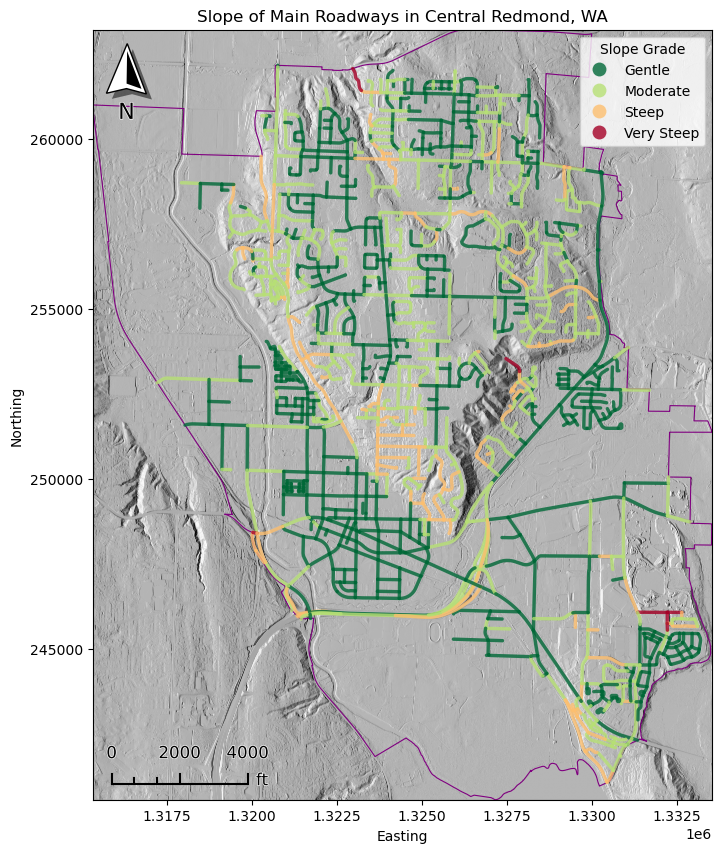

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster data and study area
hillshade_plot = ax.imshow(hillshade_array, cmap='gray', extent=plt_extent)
study_area.plot(ax=ax, color='None', edgecolor='purple', linewidth=0.8)

# Plot the buffered roadways with slope classification
redmond_roads_gdf_50ft.plot(
    ax=ax,
    column='slope_class',
    cmap='RdYlGn_r',
    alpha=0.8,
    linewidth=0.3,
    legend=True,
    legend_kwds={'title': 'Slope Grade'}
)

# Add a legend, north arrow, and scale bar
north_arrow(ax, location="upper left", rotation={"crs": redmond_roads_gdf.crs, "reference": "center"})
scale_bar(ax, location="lower left", style="ticks", bar={"projection": redmond_roads_gdf.crs, "unit": "ftUS", "max": 4000, "major_div": 2, "minor_div":3})
plt.title('Slope of Main Roadways in Central Redmond, WA')

# Add title and labels
plt.xlabel('Easting')
plt.ylabel('Northing')


### Rasterstats Comparison

Rasterstats is another Python module that calculates zonal statistics with boundaries or zones and raster datasets as arrays. Unlike the Geopandas and Rasterio zonal statistics tool we built, Rasterstats accepts a list of statistics. Rasterstats offers a concise option for zonal statistic analysis, but requires a customized Python environment and was not available in the base ArcGIS Python 3 environment for ArcGIS at the time this repository was published (and hopefully before you found it). The standalone scripts in this repository demonstrate how to integrate Geopandas and Rasterio into ArcGIS environments. We will compare results between Rasterstats and the Geopandas-Rasterio method as a way to validate the Geopandas-Rasterio method.


In [34]:
# Create a statistics list for cell count, mean, and standard deviation (std)
stats=['count', 'mean', 'std']

In [35]:
# Call zonal_stats to calculate statistics for the buffered roads and use the masked slope array to set the other inputs. Read the documentation for Rasterstats, GeoPandas, and Rasterio to understand the parameters.
redmond_roads_50ft_stats = rasterstats.zonal_stats(redmond_roads_gdf_50ft, slope_perc_array,
                                            affine=redmond_slope_perc.transform, nodata=redmond_slope_perc.nodata, stats=stats)

In [36]:
# Create a Pandas df from the Rasterstats results
rasterstats_df = pd.DataFrame(redmond_roads_50ft_stats, columns=stats)
rasterstats_df

count       mean        std
0     18676  16.333483  18.089269
1     11445   9.919880   5.812102
2     12283   6.404775   5.360127
3     28310   9.475986   7.874382
4     41267  11.136482  10.847803
...     ...        ...        ...
1515   6741  16.022048  18.487181
1516  12395  30.373802  23.152969
1517  15652  10.775833  13.927460
1518   8785  14.613905  15.615956
1519  19213   9.967460  10.665153

[1520 rows x 3 columns]

In [37]:
# Assuming both dfs have a common 'ID' column, join rasterstats_df to redmond_roads_gdf_50ft
redmond_roads_gdf_50ft_rs_join = redmond_roads_gdf_50ft.join(rasterstats_df)
redmond_roads_gdf_50ft_rs_join

StreetName         FromStreet      ToStreet  \
0        NE 116th ST        167th PL NE   167th PL NE   
1        NE 116th ST        176th PL NE  176th AVE NE   
2        NE 114th CT  W of 159th AVE NE  159th AVE NE   
3        NE 114th ST  W of 148th AVE NE  148th AVE NE   
4     RED-WOOD RD NE        NE 113th CT   NE 116th ST   
...              ...                ...           ...   
1515     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1516    192nd AVE NE       191st AVE NE   NE 69th CIR   
1517     NE 69th CIR        NE 69th CIR    NE 70th ST   
1518     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1519    188th AVE NE       188th AVE NE    NE 70th ST   

                                               geometry  cell_count  \
0     POLYGON ((1324375.024 259430.934, 1324379.918 ...       19041   
1     POLYGON ((1327083.655 259358.493, 1327232.295 ...       11681   
2     POLYGON ((1321674.046 259077.955, 1321674.45 2...       12557   
3     POLYGON ((1318098.49 258745.577, 1318099.366 2...       28828   
4     POLYGON ((1320641.017 259499.219, 1320641.469 ...       41998   
...                                                 ...         ...   
1515  POLYGON ((1332322.63 245646.177, 1332320.234 2...        6893   
1516  POLYGON ((1332161.94 245707.139, 1332161.916 2...       12678   
1517  POLYGON ((1332332.166 245895.207, 1332332.803 ...       15969   
1518  POLYGON ((1332304.663 245830.908, 1332304.668 ...        8995   
1519  POLYGON ((1331297.202 246030.049, 1331297.17 2...       19631   

      mean_elev_ft  min_slope_%  max_slope_%  mean_slope_%  mean_slope_std  \
0       276.278688     0.252355   239.191376     16.277520       17.955291   
1       222.748994     0.119722    67.267960      9.969143        5.941382   
2       247.744923     0.026077    76.766327      6.418974        5.367366   
3        32.806479     0.015104    65.881775      9.408861        7.857528   
4       205.727701     0.030132    91.540848     11.151787       10.825096   
...            ...          ...          ...           ...             ...   
1515    138.891974     0.114905    95.899033     16.050704       18.487779   
1516    128.058112     0.057999    93.004593     30.234796       23.203174   
1517    141.915806     0.046515   103.240211     10.788101       13.938386   
1518    141.051862     0.123526    73.318863     14.728122       15.647530   
1519    114.202639     0.048805    73.832268     10.044362       10.725548   

     slope_class  count       mean        std  
0          Steep  18676  16.333483  18.089269  
1       Moderate  11445   9.919880   5.812102  
2         Gentle  12283   6.404775   5.360127  
3       Moderate  28310   9.475986   7.874382  
4       Moderate  41267  11.136482  10.847803  
...          ...    ...        ...        ...  
1515       Steep   6741  16.022048  18.487181  
1516  Very Steep  12395  30.373802  23.152969  
1517    Moderate  15652  10.775833  13.927460  
1518    Moderate   8785  14.613905  15.615956  
1519    Moderate  19213   9.967460  10.665153  

[1520 rows x 14 columns]


The results from Rasterstats are slightly different from what we obtained earlier with the Geopandas-Rasterio method and NumPy functions. The next cells will compare the results and determine if raster cells within the zones are following similar data trends from each zonal statistics method. Here's an early hint: find the 'all_touched' argument for rasterstats.zonal_stats() and rasterio.mask.mask().


In [38]:
# Clean up the df by renaming columns and dropping unnecessary columns
redmond_roads_gdf_50ft_rs_join.rename(columns={
    'cell_count': 'count_gpd-rio',
    'mean_slope_%': 'mean_gpd-rio',
    'mean_slope_std': 'std_gpd-rio',
    'count': 'count_rstats',
    'mean': 'mean_rstats',
    'std': 'std_rstats'
}, inplace=True)
# Drop columns
redmond_roads_gdf_50ft_rs_join.drop(columns=['mean_elev_ft', 'min_slope_%', 'max_slope_%', 'slope_class'], inplace=True)
# Check the cleaned df
redmond_roads_gdf_50ft_rs_join

StreetName         FromStreet      ToStreet  \
0        NE 116th ST        167th PL NE   167th PL NE   
1        NE 116th ST        176th PL NE  176th AVE NE   
2        NE 114th CT  W of 159th AVE NE  159th AVE NE   
3        NE 114th ST  W of 148th AVE NE  148th AVE NE   
4     RED-WOOD RD NE        NE 113th CT   NE 116th ST   
...              ...                ...           ...   
1515     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1516    192nd AVE NE       191st AVE NE   NE 69th CIR   
1517     NE 69th CIR        NE 69th CIR    NE 70th ST   
1518     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1519    188th AVE NE       188th AVE NE    NE 70th ST   

                                               geometry  count_gpd-rio  \
0     POLYGON ((1324375.024 259430.934, 1324379.918 ...          19041   
1     POLYGON ((1327083.655 259358.493, 1327232.295 ...          11681   
2     POLYGON ((1321674.046 259077.955, 1321674.45 2...          12557   
3     POLYGON ((1318098.49 258745.577, 1318099.366 2...          28828   
4     POLYGON ((1320641.017 259499.219, 1320641.469 ...          41998   
...                                                 ...            ...   
1515  POLYGON ((1332322.63 245646.177, 1332320.234 2...           6893   
1516  POLYGON ((1332161.94 245707.139, 1332161.916 2...          12678   
1517  POLYGON ((1332332.166 245895.207, 1332332.803 ...          15969   
1518  POLYGON ((1332304.663 245830.908, 1332304.668 ...           8995   
1519  POLYGON ((1331297.202 246030.049, 1331297.17 2...          19631   

      mean_gpd-rio  std_gpd-rio  count_rstats  mean_rstats  std_rstats  
0        16.277520    17.955291         18676    16.333483   18.089269  
1         9.969143     5.941382         11445     9.919880    5.812102  
2         6.418974     5.367366         12283     6.404775    5.360127  
3         9.408861     7.857528         28310     9.475986    7.874382  
4        11.151787    10.825096         41267    11.136482   10.847803  
...            ...          ...           ...          ...         ...  
1515     16.050704    18.487779          6741    16.022048   18.487181  
1516     30.234796    23.203174         12395    30.373802   23.152969  
1517     10.788101    13.938386         15652    10.775833   13.927460  
1518     14.728122    15.647530          8785    14.613905   15.615956  
1519     10.044362    10.725548         19213     9.967460   10.665153  

[1520 rows x 10 columns]


**.describe():** The .describe() method summarizes statistics for a Pandas DataFrame or GeoPandas GeoDataFrame. We will use .describe() on each zonal statistic to compare the distribution of values between the GeoPandas-Rasterio (gpd-rio) and Rasterstats (rstats) methods.
 

In [39]:
# Create a df to compare statistics of mean slope values
mean_stats_df = pd.DataFrame({
    'GeoPandas-Rasterio Mean Slope': redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'].describe(),
    'Rasterstats Mean Slope': redmond_roads_gdf_50ft_rs_join['mean_rstats'].describe()
})

mean_stats_df['Difference'] = mean_stats_df['GeoPandas-Rasterio Mean Slope'] - mean_stats_df['Rasterstats Mean Slope']
mean_stats_df

GeoPandas-Rasterio Mean Slope  Rasterstats Mean Slope  Difference
count                    1520.000000             1520.000000    0.000000
mean                        9.400733                9.368414    0.032319
std                         4.476113                4.466732    0.009381
min                         2.662925                2.631596    0.031330
25%                         6.152912                6.139533    0.013378
50%                         8.364526                8.317802    0.046724
75%                        11.588539               11.576679    0.011860
max                        43.027566               43.359728   -0.332162

In [40]:
# Create a df to compare statistics of the std values
std_stats_df = pd.DataFrame({
    'GeoPandas-Rasterio Std. Dev.': redmond_roads_gdf_50ft_rs_join['std_gpd-rio'].describe(),
    'Rasterstats Std. Dev.': redmond_roads_gdf_50ft_rs_join['std_rstats'].describe()
})

std_stats_df['Difference'] = std_stats_df['GeoPandas-Rasterio Std. Dev.'] - std_stats_df['Rasterstats Std. Dev.']
std_stats_df

GeoPandas-Rasterio Std. Dev.  Rasterstats Std. Dev.  Difference
count                   1520.000000            1520.000000    0.000000
mean                       8.908913               8.862836    0.046076
std                        5.891549               5.885006    0.006543
min                        1.641672               1.494060    0.147612
25%                        5.086747               5.062690    0.024057
50%                        7.384022               7.342201    0.041820
75%                       10.529655              10.505679    0.023975
max                       57.486216              56.109953    1.376263

In [41]:
# Create a df to compare statistics of counts
counts_stats_df = pd.DataFrame({
    'GeoPandas-Rasterio Cell Count': redmond_roads_gdf_50ft_rs_join['count_gpd-rio'].describe(),
    'Rasterstats Cell Count': redmond_roads_gdf_50ft_rs_join['count_rstats'].describe()
})

counts_stats_df['Difference'] = counts_stats_df['GeoPandas-Rasterio Cell Count'] - counts_stats_df['Rasterstats Cell Count']
counts_stats_df

GeoPandas-Rasterio Cell Count  Rasterstats Cell Count   Difference
count                    1520.000000             1520.000000     0.000000
mean                    20657.526974            20238.110526   419.416447
std                     15887.756395            15616.709855   271.046540
min                      1827.000000             1757.000000    70.000000
25%                     11768.250000            11500.750000   267.500000
50%                     16180.500000            15810.500000   370.000000
75%                     24501.500000            23993.250000   508.250000
max                    181288.000000           178415.000000  2873.000000

In [42]:
# Create a df that is the difference between the GeoPandas-Rasterio and Rasterstats results
difference_df = redmond_roads_gdf_50ft_rs_join.copy()
difference_df['count_diff'] = difference_df['count_gpd-rio'] - difference_df['count_rstats']
difference_df['mean_diff'] = difference_df['mean_gpd-rio'] - difference_df['mean_rstats']
difference_df['std_diff'] = difference_df['std_gpd-rio'] - difference_df['std_rstats']
difference_df

StreetName         FromStreet      ToStreet  \
0        NE 116th ST        167th PL NE   167th PL NE   
1        NE 116th ST        176th PL NE  176th AVE NE   
2        NE 114th CT  W of 159th AVE NE  159th AVE NE   
3        NE 114th ST  W of 148th AVE NE  148th AVE NE   
4     RED-WOOD RD NE        NE 113th CT   NE 116th ST   
...              ...                ...           ...   
1515     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1516    192nd AVE NE       191st AVE NE   NE 69th CIR   
1517     NE 69th CIR        NE 69th CIR    NE 70th ST   
1518     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1519    188th AVE NE       188th AVE NE    NE 70th ST   

                                               geometry  count_gpd-rio  \
0     POLYGON ((1324375.024 259430.934, 1324379.918 ...          19041   
1     POLYGON ((1327083.655 259358.493, 1327232.295 ...          11681   
2     POLYGON ((1321674.046 259077.955, 1321674.45 2...          12557   
3     POLYGON ((1318098.49 258745.577, 1318099.366 2...          28828   
4     POLYGON ((1320641.017 259499.219, 1320641.469 ...          41998   
...                                                 ...            ...   
1515  POLYGON ((1332322.63 245646.177, 1332320.234 2...           6893   
1516  POLYGON ((1332161.94 245707.139, 1332161.916 2...          12678   
1517  POLYGON ((1332332.166 245895.207, 1332332.803 ...          15969   
1518  POLYGON ((1332304.663 245830.908, 1332304.668 ...           8995   
1519  POLYGON ((1331297.202 246030.049, 1331297.17 2...          19631   

      mean_gpd-rio  std_gpd-rio  count_rstats  mean_rstats  std_rstats  \
0        16.277520    17.955291         18676    16.333483   18.089269   
1         9.969143     5.941382         11445     9.919880    5.812102   
2         6.418974     5.367366         12283     6.404775    5.360127   
3         9.408861     7.857528         28310     9.475986    7.874382   
4        11.151787    10.825096         41267    11.136482   10.847803   
...            ...          ...           ...          ...         ...   
1515     16.050704    18.487779          6741    16.022048   18.487181   
1516     30.234796    23.203174         12395    30.373802   23.152969   
1517     10.788101    13.938386         15652    10.775833   13.927460   
1518     14.728122    15.647530          8785    14.613905   15.615956   
1519     10.044362    10.725548         19213     9.967460   10.665153   

      count_diff  mean_diff  std_diff  
0            365  -0.055963 -0.133977  
1            236   0.049264  0.129280  
2            274   0.014199  0.007240  
3            518  -0.067124 -0.016854  
4            731   0.015305 -0.022707  
...          ...        ...       ...  
1515         152   0.028656  0.000598  
1516         283  -0.139006  0.050205  
1517         317   0.012268  0.010926  
1518         210   0.114216  0.031575  
1519         418   0.076902  0.060395  

[1520 rows x 13 columns]


**What do you notice?** 

It seems the cell counts differ the most between the methods (It's not too late to check out the all_touched option). The next code cells will create histograms and scatterplots to examine the distribution of mean slope values and cell counts.


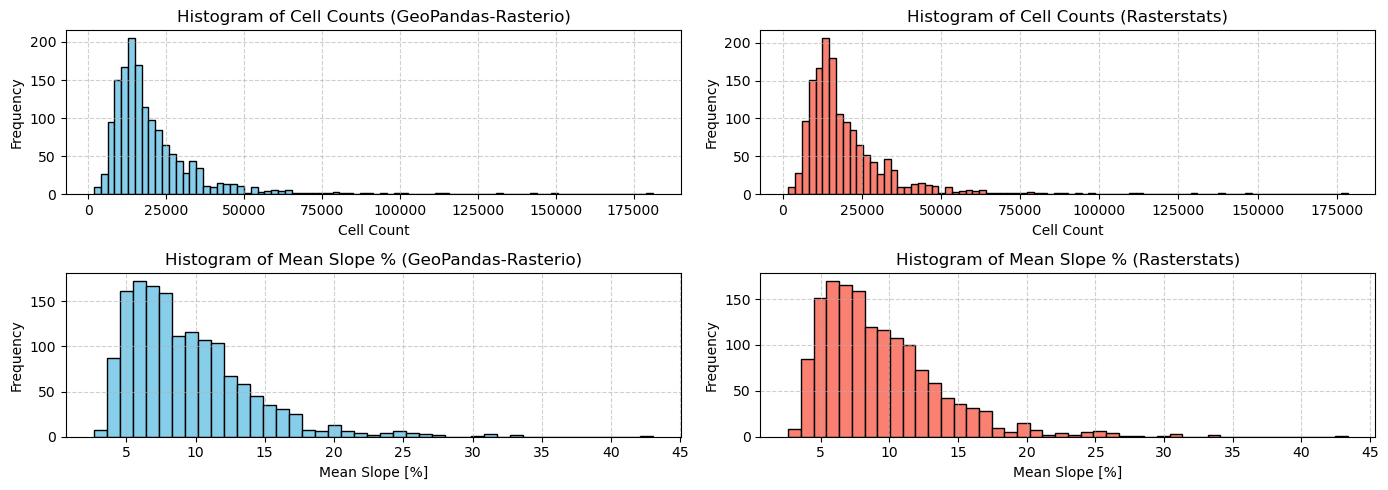

In [43]:
# Plot histograms side by side
# Use the Freedman-Diaconis rule for binning (bins='fd') 
fig, ax = plt.subplots(2, 2, figsize=(14, 5))

# Add grid lines to all subplots
for row in ax:
    for a in row:
        a.grid(True, linestyle='--', alpha=0.6)

# Histogram for count_gpd-rio
ax[0][0].hist(redmond_roads_gdf_50ft_rs_join['count_gpd-rio'].dropna(), bins='fd', color='skyblue', edgecolor='black')
ax[0][0].set_title('Histogram of Cell Counts (GeoPandas-Rasterio)')
ax[0][0].set_xlabel('Cell Count')
ax[0][0].set_ylabel('Frequency')

# Histogram for count_rstats
ax[0][1].hist(redmond_roads_gdf_50ft_rs_join['count_rstats'].dropna(), bins='fd', color='salmon', edgecolor='black')
ax[0][1].set_title('Histogram of Cell Counts (Rasterstats)')
ax[0][1].set_xlabel('Cell Count')
ax[0][1].set_ylabel('Frequency')

# Histogram for mean_gpd-rio
ax[1][0].hist(redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'].dropna(), bins='fd', color='skyblue', edgecolor='black')
ax[1][0].set_title('Histogram of Mean Slope % (GeoPandas-Rasterio)')
ax[1][0].set_xlabel('Mean Slope [%]')
ax[1][0].set_ylabel('Frequency')

# Histogram for mean_rstats
ax[1][1].hist(redmond_roads_gdf_50ft_rs_join['mean_rstats'].dropna(), bins='fd', color='salmon', edgecolor='black')
ax[1][1].set_title('Histogram of Mean Slope % (Rasterstats)')
ax[1][1].set_xlabel('Mean Slope [%]')
ax[1][1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Will stacking the histograms help interpret the distributions of cell counts and mean slope?


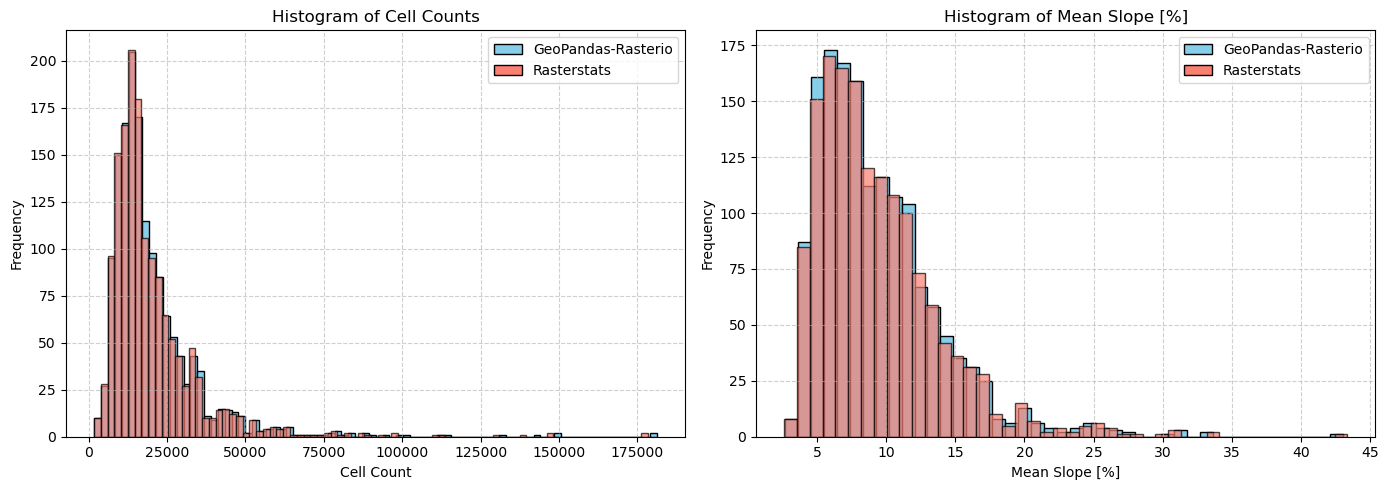

In [44]:
# Plot the histograms stacked
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Add grid lines to all subplots
for a in ax:
    a.grid(True, linestyle='--', alpha=0.6)

# Histogram for cell counts
ax[0].hist(redmond_roads_gdf_50ft_rs_join['count_gpd-rio'].dropna(), histtype='barstacked', bins='fd', color='skyblue', edgecolor='black')
ax[0].hist(redmond_roads_gdf_50ft_rs_join['count_rstats'].dropna(), histtype='barstacked', bins='fd', color='salmon', edgecolor='black', alpha=0.7)
ax[0].set_title('Histogram of Cell Counts')
ax[0].set_xlabel('Cell Count')
ax[0].set_ylabel('Frequency')

# Histogram for mean slope
ax[1].hist(redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'].dropna(),  bins='fd', color='skyblue', edgecolor='black')
ax[1].hist(redmond_roads_gdf_50ft_rs_join['mean_rstats'].dropna(), bins='fd', color='salmon', edgecolor='black', alpha=0.7)
ax[1].set_title('Histogram of Mean Slope [%]')
ax[1].set_xlabel('Mean Slope [%]')
ax[1].set_ylabel('Frequency')


# Add legends 
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='GeoPandas-Rasterio'),
    Patch(facecolor='salmon', edgecolor='black', label='Rasterstats')
]
ax[0].legend(handles=legend_elements, loc='upper right')
ax[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()



The distributions of cell counts and mean slope appear to have similar trends, but the GeoPandas-Rasterio method yields greater cell counts and higher mean slope values. We used the same zones for each method, would having more cells within the zones yield higher mean slope values? Maybe a few scatter plots can help us confirm that results from the Geopandas-Rasterio method are greater.


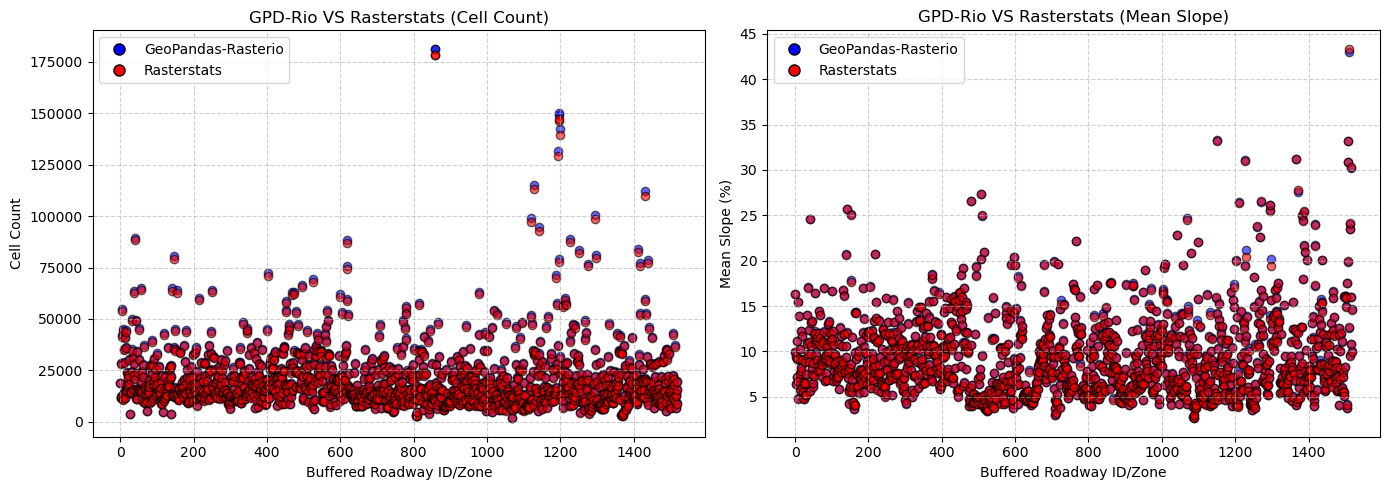

In [45]:
# Scatterplots of cell counts and mean slope within buffered roadways
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Add grid lines to all subplots
for a in ax:
    a.grid(True, linestyle='--', alpha=0.6)

# Scatterplot for GeoPandas-Rasterio cell counts
ax[0].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['count_gpd-rio'], alpha=0.6, color='blue', edgecolor='black')

# Scatterplot for Rasterstats cell counts
ax[0].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['count_rstats'], alpha=0.6, color='red', edgecolor='black')
ax[0].set_title('GPD-Rio VS Rasterstats (Cell Count)')
ax[0].set_xlabel('Buffered Roadway ID/Zone')
ax[0].set_ylabel('Cell Count')

# Scatterplot for GeoPandas-Rasterio mean slope
ax[1].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], alpha=0.6, color='blue', edgecolor='black')

# Scatterplot for Rasterstats mean slope
ax[1].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['mean_rstats'], alpha=0.6, color='red', edgecolor='black')
ax[1].set_title('GPD-Rio VS Rasterstats (Mean Slope)')
ax[1].set_xlabel('Buffered Roadway ID/Zone')
ax[1].set_ylabel('Mean Slope (%)')

# Make a legend with dot maerkers
dot_legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='GeoPandas-Rasterio',
           markerfacecolor='blue', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Rasterstats',
           markerfacecolor='red', markeredgecolor='black', markersize=8)
]
ax[0].legend(handles=dot_legend_elements, loc='upper left')
ax[1].legend(handles=dot_legend_elements, loc='upper left')
plt.tight_layout()
plt.show()


The plots for both zonal statistics tools are similar, but cell counts and mean slope are greater in some buffered roadways with the GeoPandas-Rasterio method. We should try plotting mean slopes against cell counts.


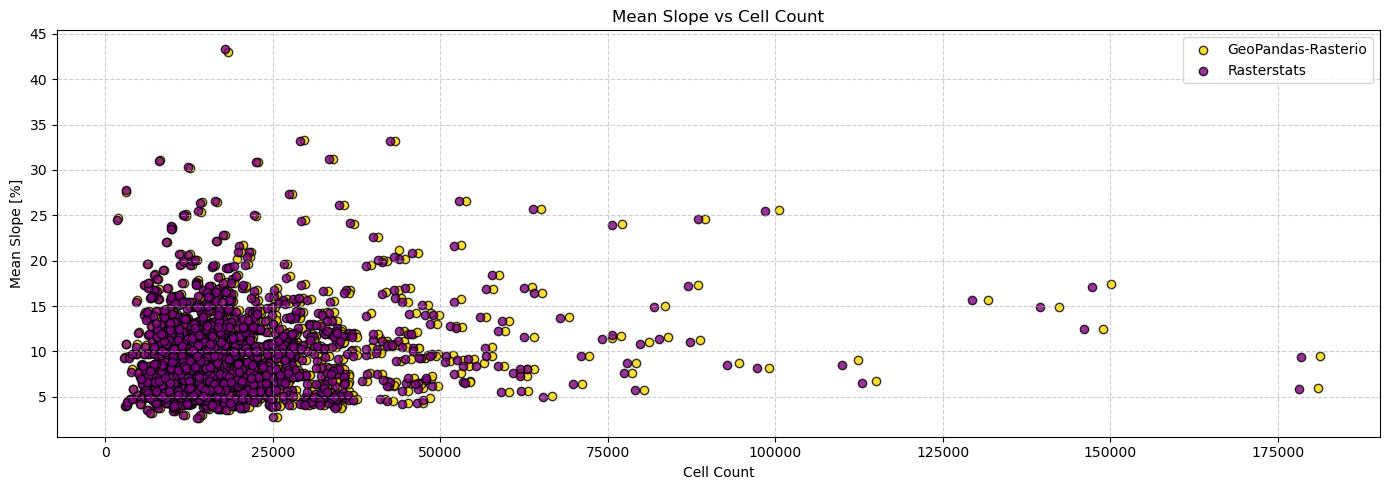

In [46]:
# Make a scatter plot of mean slope vs cell count
fig, ax = plt.subplots(figsize=(14, 5))

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.6)

# Scatter plots
ax.scatter(redmond_roads_gdf_50ft_rs_join['count_gpd-rio'], redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], alpha=0.8, color='gold', edgecolor='black', label='GeoPandas-Rasterio')
ax.scatter(redmond_roads_gdf_50ft_rs_join['count_rstats'], redmond_roads_gdf_50ft_rs_join['mean_rstats'], alpha=0.8, color='purple', edgecolor='black', label='Rasterstats')

ax.set_title('Mean Slope vs Cell Count')
ax.set_xlabel('Cell Count')
ax.set_ylabel('Mean Slope [%]')
ax.legend()

plt.tight_layout()
plt.show()


Although there does not seem to be a meaningful correlation between mean slope and cell count, the scatter plots demonstrate a shift in values obtained for each zone. The buffered roadways have a higher mean slope, but not by a significant amount, with higher cell counts in the GeoPandas-Rasterio method. For our last plot, we will examine the spread of slope values (standard deviation) over mean slopes within the zones. 


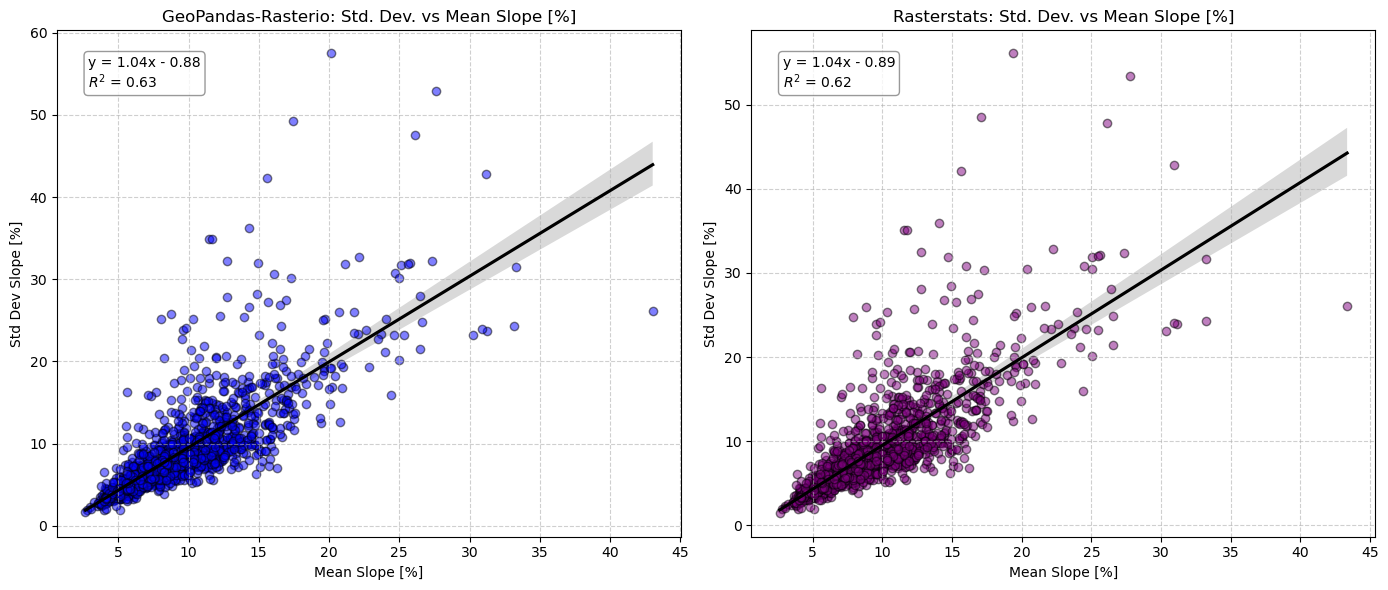

In [47]:
# Scatter plots of standard deviation vs mean slope
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 6)

# Add grid lines to both subplots
for a in ax:
    a.grid(True, linestyle='--', alpha=0.6)

# Seaborn regression line for GeoPandas-Rasterio
seaborn.regplot(
    x=redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'],
    y=redmond_roads_gdf_50ft_rs_join['std_gpd-rio'],
    scatter=False,
    ax=ax[0],
    color='black',
    line_kws={'label': 'Seaborn Linear Fit'}
)

# Calculate regression coefficients for GeoPandas-Rasterio

slope, intercept, r_value, p_value, std_err = linregress(
    redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], redmond_roads_gdf_50ft_rs_join['std_gpd-rio']
)
reg_label = f'y = {slope:.2f}x {"-" if intercept < 0 else "+"} {abs(intercept):.2f}\n$R^2$ = {r_value**2:.2f}'
ax[0].text(
    0.05, 0.95, reg_label, transform=ax[0].transAxes,
    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8)
)

# Seaborn regression lines for Rasterstats
seaborn.regplot(
    x=redmond_roads_gdf_50ft_rs_join['mean_rstats'],
    y=redmond_roads_gdf_50ft_rs_join['std_rstats'],
    scatter=False,
    ax=ax[1],
    color='black',
    line_kws={'label': 'Seaborn Linear Fit'}
)

# Calculate regression coefficients for Rasterstats
slope_rs, intercept_rs, r_value_rs, p_value_rs, std_err_rs = linregress(
    redmond_roads_gdf_50ft_rs_join['mean_rstats'], redmond_roads_gdf_50ft_rs_join['std_rstats']
)
reg_label_rs = f'y = {slope_rs:.2f}x {"-" if intercept_rs < 0 else "+"} {abs(intercept_rs):.2f}\n$R^2$ = {r_value_rs**2:.2f}'
ax[1].text(
    0.05, 0.95, reg_label_rs, transform=ax[1].transAxes,
    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8)
)

# Scatter plot for 'mean_gpd-rio' vs 'std_gpd-rio' from redmond_roads_gdf_50ft_rs_join
ax[0].scatter(redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], redmond_roads_gdf_50ft_rs_join['std_gpd-rio'], alpha=0.5, color='blue', edgecolor='black')
ax[0].set_title('GeoPandas-Rasterio: Std. Dev. vs Mean Slope [%]')
ax[0].set_xlabel('Mean Slope [%]')
ax[0].set_ylabel('Std Dev Slope [%]')

# Scatter plot for 'mean_rstats' vs 'std_rstats' from redmond_roads_gdf_50ft_rs_join
ax[1].scatter(redmond_roads_gdf_50ft_rs_join['mean_rstats'], redmond_roads_gdf_50ft_rs_join['std_rstats'], alpha=0.5, color='purple', edgecolor='black')
ax[1].set_title('Rasterstats: Std. Dev. vs Mean Slope [%]')
ax[1].set_xlabel('Mean Slope [%]')
ax[1].set_ylabel('Std Dev Slope [%]')

plt.tight_layout()
plt.show()


The plots demonstrate that slopes in each zone generally follow the same trend between the spread of values and the mean for both methods. Overall, the Geopandas-Rasterio method collects more cells per zone but yields statistics that are similar to RasterStats.
 


**Can you show what happens when all_touched is set to False?**

I would love to, and I'll keep it short so you can try the other scripts in this repository.


In [48]:
# Function to create a masked array for slope data with all_touched=False
def slope_masked_array_2(geom, data=redmond_slope_perc, **mask_args):
    slope_masked_2, slope_mask_transform_2 = mask(dataset=data, shapes=[geom],
                                  crop=True, all_touched=False, filled=False, indexes=1)
    return slope_masked_2

In [49]:
# Zonal statistics for roadways with all_touched=False
redmond_roads_gdf_50ft_rs_join['count_gpd-rio'] = redmond_roads_gdf_50ft_rs_join.geometry.apply(slope_masked_array_2).apply(cell_count)
redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'] = redmond_roads_gdf_50ft_rs_join.geometry.apply(slope_masked_array_2).apply(np.mean)
redmond_roads_gdf_50ft_rs_join['std_gpd-rio'] = redmond_roads_gdf_50ft_rs_join.geometry.apply(slope_masked_array_2).apply(np.std)
redmond_roads_gdf_50ft_rs_join

StreetName         FromStreet      ToStreet  \
0        NE 116th ST        167th PL NE   167th PL NE   
1        NE 116th ST        176th PL NE  176th AVE NE   
2        NE 114th CT  W of 159th AVE NE  159th AVE NE   
3        NE 114th ST  W of 148th AVE NE  148th AVE NE   
4     RED-WOOD RD NE        NE 113th CT   NE 116th ST   
...              ...                ...           ...   
1515     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1516    192nd AVE NE       191st AVE NE   NE 69th CIR   
1517     NE 69th CIR        NE 69th CIR    NE 70th ST   
1518     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1519    188th AVE NE       188th AVE NE    NE 70th ST   

                                               geometry  count_gpd-rio  \
0     POLYGON ((1324375.024 259430.934, 1324379.918 ...          18676   
1     POLYGON ((1327083.655 259358.493, 1327232.295 ...          11445   
2     POLYGON ((1321674.046 259077.955, 1321674.45 2...          12283   
3     POLYGON ((1318098.49 258745.577, 1318099.366 2...          28310   
4     POLYGON ((1320641.017 259499.219, 1320641.469 ...          41267   
...                                                 ...            ...   
1515  POLYGON ((1332322.63 245646.177, 1332320.234 2...           6741   
1516  POLYGON ((1332161.94 245707.139, 1332161.916 2...          12395   
1517  POLYGON ((1332332.166 245895.207, 1332332.803 ...          15652   
1518  POLYGON ((1332304.663 245830.908, 1332304.668 ...           8785   
1519  POLYGON ((1331297.202 246030.049, 1331297.17 2...          19213   

      mean_gpd-rio  std_gpd-rio  count_rstats  mean_rstats  std_rstats  
0        16.333483    18.089269         18676    16.333483   18.089269  
1         9.919880     5.812102         11445     9.919880    5.812102  
2         6.404775     5.360127         12283     6.404775    5.360127  
3         9.475986     7.874382         28310     9.475986    7.874382  
4        11.136482    10.847803         41267    11.136482   10.847803  
...            ...          ...           ...          ...         ...  
1515     16.022048    18.487181          6741    16.022048   18.487181  
1516     30.373802    23.152969         12395    30.373802   23.152969  
1517     10.775833    13.927460         15652    10.775833   13.927460  
1518     14.613905    15.615956          8785    14.613905   15.615956  
1519      9.967460    10.665153         19213     9.967460   10.665153  

[1520 rows x 10 columns]

In [50]:
# Create a DataFrame to compare statistics of mean slope values
mean_stats_df_2 = pd.DataFrame({
    'GeoPandas-Rasterio Mean Slope': redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'].describe(),
    'Rasterstats Mean Slope': redmond_roads_gdf_50ft_rs_join['mean_rstats'].describe()
})

mean_stats_df_2['Difference'] = mean_stats_df_2['GeoPandas-Rasterio Mean Slope'] - mean_stats_df_2['Rasterstats Mean Slope']
mean_stats_df_2

GeoPandas-Rasterio Mean Slope  Rasterstats Mean Slope  Difference
count                    1520.000000             1520.000000         0.0
mean                        9.368414                9.368414         0.0
std                         4.466732                4.466732         0.0
min                         2.631596                2.631596         0.0
25%                         6.139533                6.139533         0.0
50%                         8.317802                8.317802         0.0
75%                        11.576679               11.576679         0.0
max                        43.359728               43.359728         0.0

In [51]:
# Create a DataFrame to compare statistics of the std values
std_stats_df_2 = pd.DataFrame({
    'GeoPandas-Rasterio Std. Dev.': redmond_roads_gdf_50ft_rs_join['std_gpd-rio'].describe(),
    'Rasterstats Std. Dev.': redmond_roads_gdf_50ft_rs_join['std_rstats'].describe()
})

std_stats_df_2['Difference'] = std_stats_df_2['GeoPandas-Rasterio Std. Dev.'] - std_stats_df_2['Rasterstats Std. Dev.']
std_stats_df_2

GeoPandas-Rasterio Std. Dev.  Rasterstats Std. Dev.  Difference
count                   1520.000000            1520.000000         0.0
mean                       8.862836               8.862836         0.0
std                        5.885006               5.885006         0.0
min                        1.494060               1.494060         0.0
25%                        5.062690               5.062690         0.0
50%                        7.342201               7.342201         0.0
75%                       10.505679              10.505679         0.0
max                       56.109953              56.109953         0.0

In [52]:
# Create a DataFrame to compare statistics of counts
counts_stats_df_2 = pd.DataFrame({
    'GeoPandas-Rasterio Cell Count': redmond_roads_gdf_50ft_rs_join['count_gpd-rio'].describe(),
    'Rasterstats Cell Count': redmond_roads_gdf_50ft_rs_join['count_rstats'].describe()
})

counts_stats_df_2['Difference'] = counts_stats_df_2['GeoPandas-Rasterio Cell Count'] - counts_stats_df_2['Rasterstats Cell Count']
counts_stats_df_2

GeoPandas-Rasterio Cell Count  Rasterstats Cell Count  Difference
count                    1520.000000             1520.000000         0.0
mean                    20238.110526            20238.110526         0.0
std                     15616.709855            15616.709855         0.0
min                      1757.000000             1757.000000         0.0
25%                     11500.750000            11500.750000         0.0
50%                     15810.500000            15810.500000         0.0
75%                     23993.250000            23993.250000         0.0
max                    178415.000000           178415.000000         0.0

In [53]:
# Create a df that is the difference between the GeoPandas-Rasterio and Rasterstats results
difference_df = redmond_roads_gdf_50ft_rs_join.copy()
difference_df['count_diff'] = difference_df['count_gpd-rio'] - difference_df['count_rstats']
difference_df['mean_diff'] = difference_df['mean_gpd-rio'] - difference_df['mean_rstats']
difference_df['std_diff'] = difference_df['std_gpd-rio'] - difference_df['std_rstats']
difference_df

StreetName         FromStreet      ToStreet  \
0        NE 116th ST        167th PL NE   167th PL NE   
1        NE 116th ST        176th PL NE  176th AVE NE   
2        NE 114th CT  W of 159th AVE NE  159th AVE NE   
3        NE 114th ST  W of 148th AVE NE  148th AVE NE   
4     RED-WOOD RD NE        NE 113th CT   NE 116th ST   
...              ...                ...           ...   
1515     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1516    192nd AVE NE       191st AVE NE   NE 69th CIR   
1517     NE 69th CIR        NE 69th CIR    NE 70th ST   
1518     NE 69th CIR        NE 69th CIR   NE 69th CIR   
1519    188th AVE NE       188th AVE NE    NE 70th ST   

                                               geometry  count_gpd-rio  \
0     POLYGON ((1324375.024 259430.934, 1324379.918 ...          18676   
1     POLYGON ((1327083.655 259358.493, 1327232.295 ...          11445   
2     POLYGON ((1321674.046 259077.955, 1321674.45 2...          12283   
3     POLYGON ((1318098.49 258745.577, 1318099.366 2...          28310   
4     POLYGON ((1320641.017 259499.219, 1320641.469 ...          41267   
...                                                 ...            ...   
1515  POLYGON ((1332322.63 245646.177, 1332320.234 2...           6741   
1516  POLYGON ((1332161.94 245707.139, 1332161.916 2...          12395   
1517  POLYGON ((1332332.166 245895.207, 1332332.803 ...          15652   
1518  POLYGON ((1332304.663 245830.908, 1332304.668 ...           8785   
1519  POLYGON ((1331297.202 246030.049, 1331297.17 2...          19213   

      mean_gpd-rio  std_gpd-rio  count_rstats  mean_rstats  std_rstats  \
0        16.333483    18.089269         18676    16.333483   18.089269   
1         9.919880     5.812102         11445     9.919880    5.812102   
2         6.404775     5.360127         12283     6.404775    5.360127   
3         9.475986     7.874382         28310     9.475986    7.874382   
4        11.136482    10.847803         41267    11.136482   10.847803   
...            ...          ...           ...          ...         ...   
1515     16.022048    18.487181          6741    16.022048   18.487181   
1516     30.373802    23.152969         12395    30.373802   23.152969   
1517     10.775833    13.927460         15652    10.775833   13.927460   
1518     14.613905    15.615956          8785    14.613905   15.615956   
1519      9.967460    10.665153         19213     9.967460   10.665153   

      count_diff  mean_diff  std_diff  
0              0        0.0       0.0  
1              0        0.0       0.0  
2              0        0.0       0.0  
3              0        0.0       0.0  
4              0        0.0       0.0  
...          ...        ...       ...  
1515           0        0.0       0.0  
1516           0        0.0       0.0  
1517           0        0.0       0.0  
1518           0        0.0       0.0  
1519           0        0.0       0.0  

[1520 rows x 13 columns]

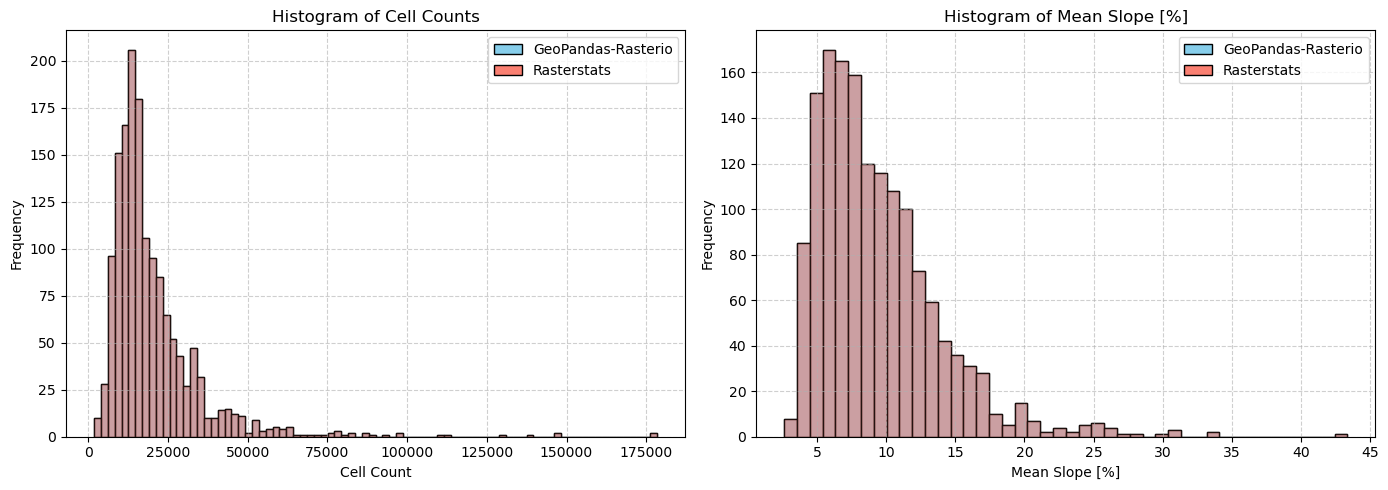

In [54]:
# Plot the histograms stacked
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Add grid lines to all subplots
for a in ax:
    a.grid(True, linestyle='--', alpha=0.6)

# Histogram for cell counts
ax[0].hist(redmond_roads_gdf_50ft_rs_join['count_gpd-rio'].dropna(), histtype='barstacked', bins='fd', color='skyblue', edgecolor='black')
ax[0].hist(redmond_roads_gdf_50ft_rs_join['count_rstats'].dropna(), histtype='barstacked', bins='fd', color='salmon', edgecolor='black', alpha=0.6)
ax[0].set_title('Histogram of Cell Counts')
ax[0].set_xlabel('Cell Count')
ax[0].set_ylabel('Frequency')

# Histogram for mean slope
ax[1].hist(redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'].dropna(),  bins='fd', color='skyblue', edgecolor='black')
ax[1].hist(redmond_roads_gdf_50ft_rs_join['mean_rstats'].dropna(), bins='fd', color='salmon', edgecolor='black', alpha=0.6)
ax[1].set_title('Histogram of Mean Slope [%]')
ax[1].set_xlabel('Mean Slope [%]')
ax[1].set_ylabel('Frequency')


# Add legends 
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='GeoPandas-Rasterio'),
    Patch(facecolor='salmon', edgecolor='black', label='Rasterstats')
]
ax[0].legend(handles=legend_elements, loc='upper right')
ax[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


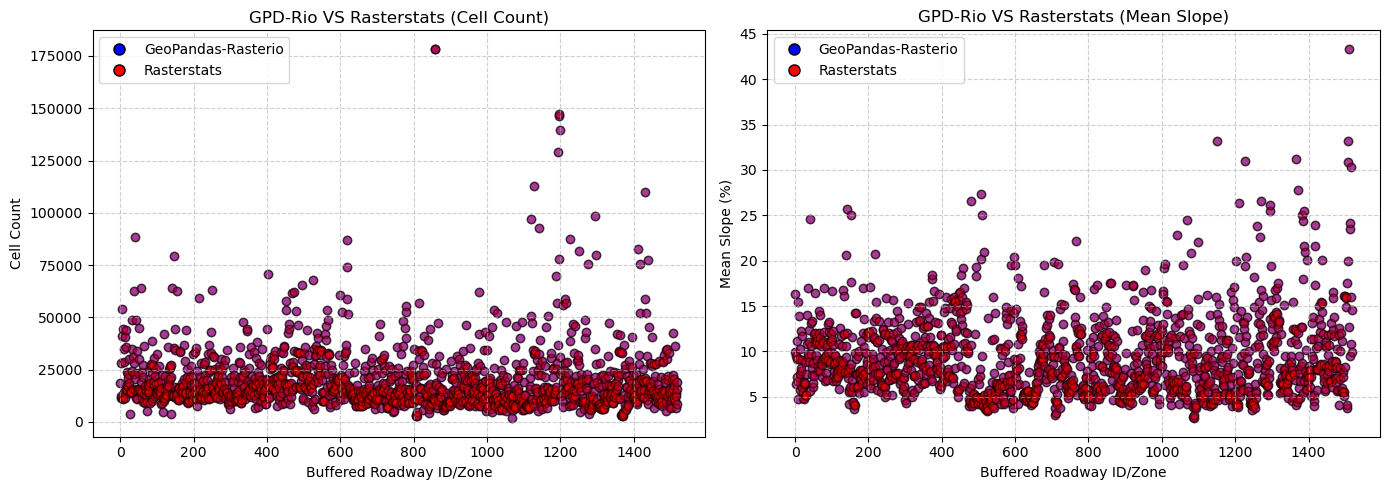

In [55]:
# Scatterplots of cell counts and mean slope within buffered roadways
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Add grid lines to all subplots
for a in ax:
    a.grid(True, linestyle='--', alpha=0.6)

# Scatterplot for GeoPandas-Rasterio cell counts
ax[0].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['count_gpd-rio'], alpha=0.6, color='blue', edgecolor='black')

# Scatterplot for Rasterstats cell counts
ax[0].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['count_rstats'], alpha=0.4, color='red', edgecolor='black')
ax[0].set_title('GPD-Rio VS Rasterstats (Cell Count)')
ax[0].set_xlabel('Buffered Roadway ID/Zone')
ax[0].set_ylabel('Cell Count')

# Scatterplot for GeoPandas-Rasterio mean slope
ax[1].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], alpha=0.6, color='blue', edgecolor='black')

# Scatterplot for Rasterstats mean slope
ax[1].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['mean_rstats'], alpha=0.4, color='red', edgecolor='black')
ax[1].set_title('GPD-Rio VS Rasterstats (Mean Slope)')
ax[1].set_xlabel('Buffered Roadway ID/Zone')
ax[1].set_ylabel('Mean Slope (%)')

# Make a legend with dot maerkers
dot_legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='GeoPandas-Rasterio',
           markerfacecolor='blue', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Rasterstats',
           markerfacecolor='red', markeredgecolor='black', markersize=8)
]
ax[0].legend(handles=dot_legend_elements, loc='upper left')
ax[1].legend(handles=dot_legend_elements, loc='upper left')
plt.tight_layout()
plt.show()

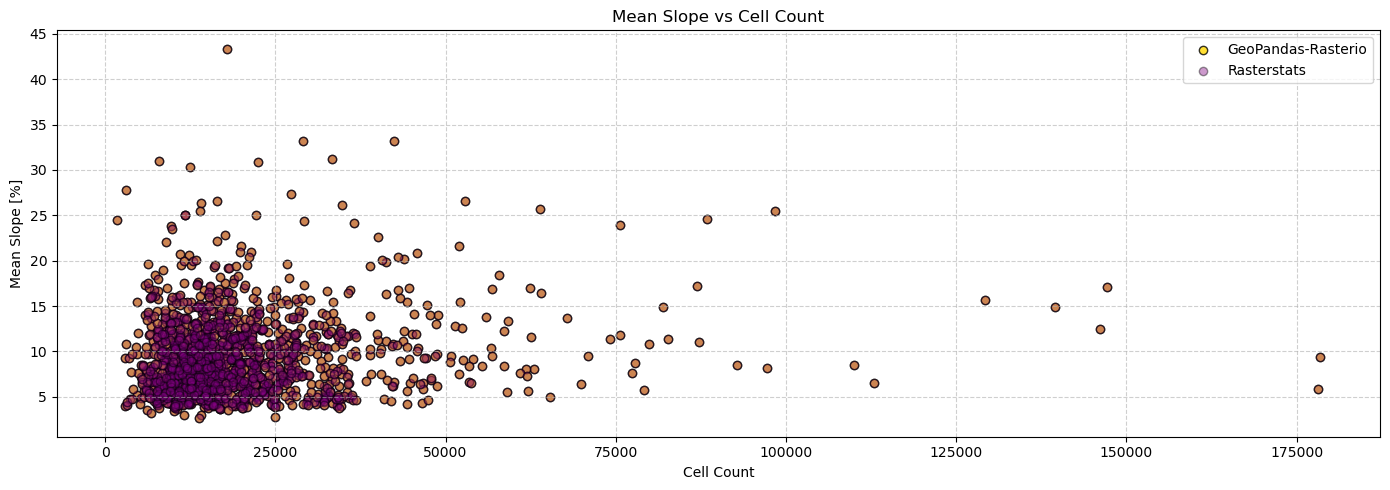

In [56]:
# Make a scatter plot of mean slope vs vcell count
fig, ax = plt.subplots(figsize=(14, 5))

# Add grid lines to the subplot
ax.grid(True, linestyle='--', alpha=0.6)

# Scatter plots
ax.scatter(redmond_roads_gdf_50ft_rs_join['count_gpd-rio'], redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], alpha=0.8, color='gold', edgecolor='black', label='GeoPandas-Rasterio')
ax.scatter(redmond_roads_gdf_50ft_rs_join['count_rstats'], redmond_roads_gdf_50ft_rs_join['mean_rstats'], alpha=0.4, color='purple', edgecolor='black', label='Rasterstats')

ax.set_title('Mean Slope vs Cell Count')
ax.set_xlabel('Cell Count')
ax.set_ylabel('Mean Slope [%]')
ax.legend()

plt.tight_layout()
plt.show()

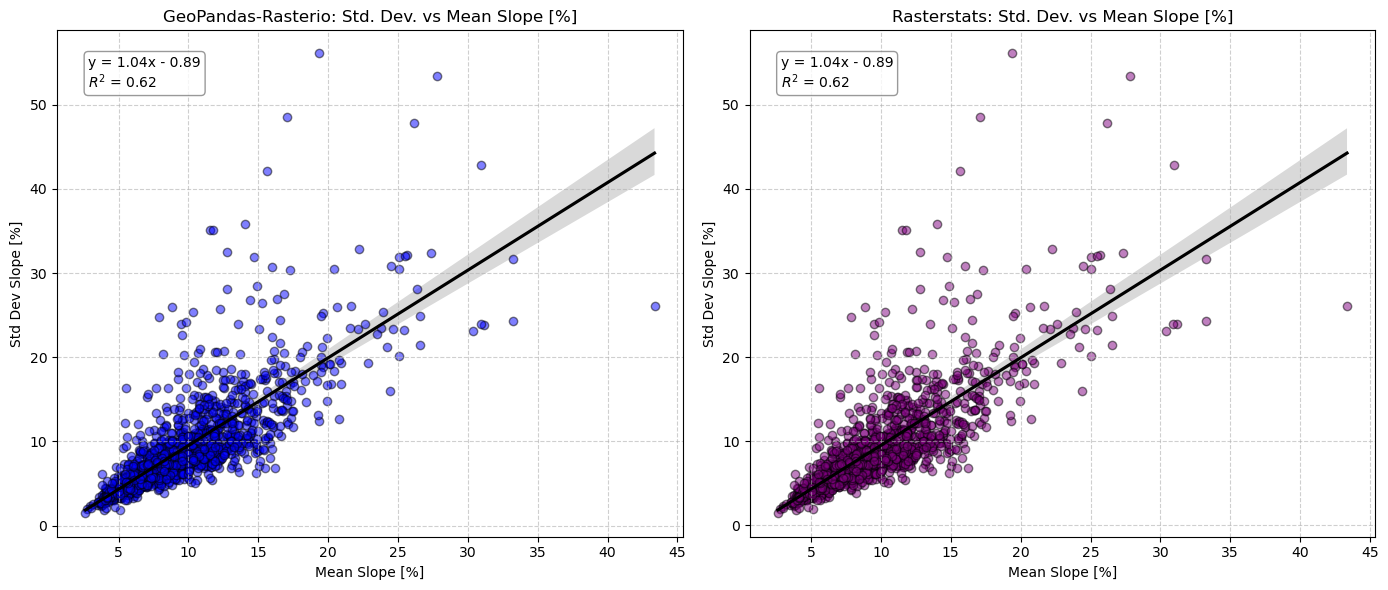

In [57]:
# Scatter plots of standard deviation vs mean slope
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 6)

# Add grid lines to both subplots
for a in ax:
    a.grid(True, linestyle='--', alpha=0.6)

# Seaborn regression line for GeoPandas-Rasterio
seaborn.regplot(
    x=redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'],
    y=redmond_roads_gdf_50ft_rs_join['std_gpd-rio'],
    scatter=False,
    ax=ax[0],
    color='black',
    line_kws={'label': 'Seaborn Linear Fit'}
)

# Calculate regression coefficients for GeoPandas-Rasterio

slope, intercept, r_value, p_value, std_err = linregress(
    redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], redmond_roads_gdf_50ft_rs_join['std_gpd-rio']
)
reg_label = f'y = {slope:.2f}x {"-" if intercept < 0 else "+"} {abs(intercept):.2f}\n$R^2$ = {r_value**2:.2f}'
ax[0].text(
    0.05, 0.95, reg_label, transform=ax[0].transAxes,
    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8)
)

# Seaborn regression lines for Rasterstats
seaborn.regplot(
    x=redmond_roads_gdf_50ft_rs_join['mean_rstats'],
    y=redmond_roads_gdf_50ft_rs_join['std_rstats'],
    scatter=False,
    ax=ax[1],
    color='black',
    line_kws={'label': 'Seaborn Linear Fit'}
)

# Calculate regression coefficients for Rasterstats
slope_rs, intercept_rs, r_value_rs, p_value_rs, std_err_rs = linregress(
    redmond_roads_gdf_50ft_rs_join['mean_rstats'], redmond_roads_gdf_50ft_rs_join['std_rstats']
)
reg_label_rs = f'y = {slope_rs:.2f}x {"-" if intercept_rs < 0 else "+"} {abs(intercept_rs):.2f}\n$R^2$ = {r_value_rs**2:.2f}'
ax[1].text(
    0.05, 0.95, reg_label_rs, transform=ax[1].transAxes,
    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8)
)

# Scatter plot for 'mean_gpd-rio' vs 'std_gpd-rio' from redmond_roads_gdf_50ft_rs_join
ax[0].scatter(redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], redmond_roads_gdf_50ft_rs_join['std_gpd-rio'], alpha=0.5, color='blue', edgecolor='black')
ax[0].set_title('GeoPandas-Rasterio: Std. Dev. vs Mean Slope [%]')
ax[0].set_xlabel('Mean Slope [%]')
ax[0].set_ylabel('Std Dev Slope [%]')

# Scatter plot for 'mean_rstats' vs 'std_rstats' from redmond_roads_gdf_50ft_rs_join
ax[1].scatter(redmond_roads_gdf_50ft_rs_join['mean_rstats'], redmond_roads_gdf_50ft_rs_join['std_rstats'], alpha=0.5, color='purple', edgecolor='black')
ax[1].set_title('Rasterstats: Std. Dev. vs Mean Slope [%]')
ax[1].set_xlabel('Mean Slope [%]')
ax[1].set_ylabel('Std Dev Slope [%]')

plt.tight_layout()
plt.show()

### Final Thoughts and Considerations

The GeoPandas-Rasterio method achieves identical results to Rasterstats when all_touched is False. Rasterstats has all_touched set to False by default, which counts cells if their centers are within a geometry. If all_touched is True, every cell is counted if it falls within a geometry, regardless of the center. You can read about the implications of having too few or too many cells for zonal statistics in other resources, but understanding the options and parameters available with any tool can help obtain meaningful analytics. Learning how to customize tools also prepares you for scenarios where you might need to explore other methods or options to acomplish a task.


### Saving Outputs to Files

Before moving on to the other scripts in the repository, save the buffered roads with the zonal statistics. You could compare these to what you get from anything ArcGIS-related, QGIS, SAGA GIS, PostGIS, or GRASS GIS...(That one scares me the most)

In [58]:
# Uncomment the line below the file type comment for the desired format
# Esri Shapefile output
#redmond_roads_gdf_50ft.to_file(r'C:\Users\brekc\OneDrive\Desktop\GIS_PROJECTS\Road_Slope_Analysis_Education_Hill\Outputs\Redmond_Roads_Slope_Stats.shp', driver='ESRI Shapefile')
# GeoPackage output
redmond_roads_gdf_50ft.to_file(r'C:\Users\brekc\OneDrive\Desktop\GIS_PROJECTS\Road_Slope_Analysis_Education_Hill\Outputs\Redmond_Roads_Slope_Stats.gpkg', driver='GPKG')
# GeoJSON output
redmond_roads_gdf_50ft.to_file(r'C:\Users\brekc\OneDrive\Desktop\GIS_PROJECTS\Road_Slope_Analysis_Education_Hill\Outputs\Redmond_Roads_Slope_Stats.geojson', driver='GeoJSON')
# File Geodatabase output
redmond_roads_gdf_50ft.to_file(r'C:\Users\brekc\OneDrive\Desktop\GIS_PROJECTS\Road_Slope_Analysis_Education_Hill\Outputs\Redmond_Roads_Slope_Stats.gdb', driver='OpenFileGDB')

c:\Users\brekc\anaconda3\envs\GEO\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'min_slope_%' to 'min_slope__'
  ogr_write(
c:\Users\brekc\anaconda3\envs\GEO\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'max_slope_%' to 'max_slope__'
  ogr_write(
c:\Users\brekc\anaconda3\envs\GEO\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'mean_slope_%' to 'mean_slope__'
  ogr_write(
